## Step1, 数据加载

In [1]:
import pandas as pd
data = pd.read_csv('./family_data.csv',index_col='family_id')
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,16,1,66,33,18,70,56,46,86,60,4
4996,88,66,20,17,26,54,81,91,59,48,2
4997,32,66,54,17,27,21,74,81,3,7,6


## Step2，数据预处理
* 1）计算Perference Cost矩阵 pcost_mat
* 2）计算Accounting Cost矩阵 acost_mat
* 3）计算每个家庭的人数 FAMILY_SIZE
* 4）每个家庭的倾向选择（choice_） DESIRED

In [2]:
# n代表家庭成员个数，如果满足第choice个需求，需要的penalty(惩罚)
def get_penalty(n, choice):
    penalty = None
    if choice == 0:
        penalty = 0
    if choice == 1:
        penalty = 50
    if choice == 2:
        penalty = 50 + 9 * n
    if choice == 3:
        penalty = 100 + 9 * n
    if choice == 4:
        penalty = 200 + 9 * n
    if choice == 5:
        penalty = 200 + 18 * n
    if choice == 6:
        penalty = 300 + 18 * n
    if choice == 7:
        penalty = 300 + 36 * n
    if choice == 8:
        penalty = 400 + 36 * n
    if choice == 9:
        penalty = 500 + (36 + 199) * n
    if choice > 9:
        penalty = 500 + (36 + 398) * n
    return penalty

In [3]:
import numpy as np

N_DAYS = 100 # 安排的天数
N_FAMILY = 5000 #家庭ID的个数
MIN_OCCUPANCY = 125 # 最小承载量
MAX_OCCUPANCY = 300 # 最大承载量
# 计算pcost_mat，每个家庭在什么时候（day0-99）访问时的penalty
# 大小5000*100的矩阵
pcost_mat = np.full(shape=(N_FAMILY,100),fill_value=999999)
for f in range(N_FAMILY):
    # 家庭成员数
    f_num = data.loc[f,'n_people']
    # 对于第f个家庭，初始化pcost = other choice下的penalty
    pcost_mat[f,:] = get_penalty(f_num,10) #初始值最大惩罚
    # 计算choice 0-9 的penalty
    for choice in range(10):# choice 0-9
        temp = data.loc[f][choice] #choice的天数
        penalty = get_penalty(f_num,choice) # 得到对应choice的惩罚
        pcost_mat[f,temp-1] = penalty # 因为下标是从0开始，所以要在天数基础上-1才是下标值
pcost_mat        

array([[2236, 2236, 2236, ..., 2236, 2236, 2236],
       [2236, 2236, 2236, ..., 2236, 2236, 2236],
       [1802, 1802, 1802, ..., 1802, 1802,    0],
       ...,
       [3104, 3104,  616, ..., 3104, 3104, 3104],
       [ 390, 2670, 2670, ..., 2670, 2670, 2670],
       [2236, 2236, 2236, ..., 2236, 2236, 2236]])

In [4]:
pcost_mat.shape

(5000, 100)

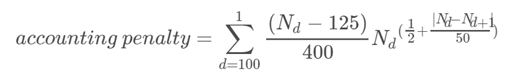

In [5]:
# 计算accounting penalty矩阵，前一天的参观人数和当天的参观人数
acost_mat = np.zeros(shape=(MAX_OCCUPANCY+1,MAX_OCCUPANCY+1),dtype=np.float64)
for i in range(acost_mat.shape[0]):# 当天安排的人数
    for j in range(acost_mat.shape[1]):# 前一天安排的人数
        diff = abs(i-j)
        acost_mat[i,j] = max(0,(i - 125) / 400 * i ** (0.5 + diff/50.0))
acost_mat

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.16316072e+15, 3.71482922e+15, 3.31477861e+15, ...,
        7.46610759e+00, 8.36716954e+00, 9.37697794e+00],
       [4.79555148e+15, 4.27883100e+15, 3.81778713e+15, ...,
        8.43020770e+00, 7.52185316e+00, 8.43020770e+00],
       [5.52415954e+15, 4.92860244e+15, 4.39725208e+15, ...,
        9.51970597e+00, 8.49339085e+00, 7.57772228e+00]])

In [6]:
FAMILY_SIZE = data['n_people'].values
FAMILY_SIZE

array([4, 4, 3, ..., 6, 5, 4], dtype=int64)

In [7]:
# DESIRED代表每个家庭的choice-1
# pcost_mat 的时间时1-100，对应的下标是0-99 所以需要-1
DESIRED = data.values[:,:-1]-1
print(len(DESIRED))
DESIRED

5000


array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]], dtype=int64)

## Step3，使用LP和MIP求解 规划方案
* 1）先使用LP 对绝大部分家庭进行规划
* 2）再使用MIP 对剩余家庭进行规划
* 3）汇总两边的结果 => 最终规划方案

In [8]:
from ortools.linear_solver import pywraplp

# 线性规划
def solveLP():
    # 线性规划优化器
    solver= pywraplp.Solver('AssignmentProblem', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    x = {} #family_id在第j天是否参观
    # 每一天有哪些家庭
    candidates = [[] for x in range(N_DAYS)] # 定义了len为100的list
    for i in range(N_FAMILY):#family_id
        for j in DESIRED[i,:]:# family_id的choice
            #print(j)
            candidates[j].append(i) # 在第j天，有第i个family参观
            # 定义决策变量x[i,j] i代表family_id,j代表第j天参观
            x[i,j] = solver.BoolVar('x[%i,%i]' %(i,j)) # x[%i,%i]中的i代表integer类型
    # print(len(candidates))
    # 每天参团人数 
    #100天外层循环
    #内层循环candidates:每一天的candidates对应5000个家庭 ,根据布尔决策变量x[i,j]=0或1 绝对哪个家庭参加（1）哪个家庭不参加（0） 
    #再结合FAMILY_SIZE统计出每天的参团人数
    #occupancy（占用率）
    daily_occupancy = [solver.Sum([x[i,j] * FAMILY_SIZE[i] for i in candidates[j]])\
                        for j in range(N_DAYS)] # j代表1-100天
    # print(len(daily_occupancy))
    
    # 每个家庭在10个choice中出现的总数
    # 外层循环5000个家庭
    # 内层循环每一个家庭的期望，根据布尔决策变量得到该家庭在0个choice中出现的总数
    # 举例：(x[1,25] + x[1,3] + x[1,81] + x[1,4] + x[1,10] + x[1,46] + x[1,37] + x[1,5] + x[1,65] + x[1,60])
    family_presence = [solver.Sum(x[i,j]  for j in DESIRED[i,:])\
                        for i in range(N_FAMILY)]
    # print(len(family_presence))
    
    # 定义目标函数 preference cost部分
    # 外层循环第i个家庭的期望
    # pcost_mat[i,j] * x[i,j]表示第i个家庭第j天是否出现，如果出现就计算它的pcost
    preference_cost = solver.Sum([pcost_mat[i,j] * x[i,j] for i in range(N_FAMILY)\
                                for j in DESIRED[i,:]])
    
    # 满足preference_cost最小
    solver.Minimize(preference_cost)
    
    # 人为增加约束条件为了更加拟合 Constraints
    for j in range(N_DAYS-1):
        # 当前人数不超过前一天人数+25
        solver.Add(daily_occupancy[j] - daily_occupancy[j+1]<=25)
        solver.Add(daily_occupancy[j+1] - daily_occupancy[j]<=25)
        
    # 每个家庭都在10个choice中出现一次
    for i in range(N_FAMILY):
        solver.Add(family_presence[i]==1)
    # 每天访问人数约束
    for j in range(N_DAYS):
        solver.Add(daily_occupancy[j]>=MIN_OCCUPANCY)
        solver.Add(daily_occupancy[j]<=MAX_OCCUPANCY)
    result = solver.Solve()
    
    temp = [(i,j,x[i,j].solution_value()) for i in range(N_FAMILY)\
             for j in DESIRED[i,:] if x[i,j].solution_value()>0]
    # 得到参观日期安排
    df = pd.DataFrame(temp,columns=['family_id','day','result'])
    return df


In [9]:
%%time
result = solveLP()

Wall time: 16.9 s


In [10]:
result

,family_id,day,result
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5068,4995,15,1.0
5069,4996,87,1.0
5070,4997,31,1.0
5071,4998,91,1.0


数据超出了5000，说明有的家庭计算结果不是唯一

In [11]:
result['result'].value_counts()

1.000000    4301
1.000000     627
0.750000       2
0.666667       2
0.666667       2
            ... 
0.750000       1
0.400000       1
0.400000       1
0.400000       1
0.947917       1
Name: result, Length: 144, dtype: int64

可以看到有的家庭被分到多天去参观

In [12]:
# 设置阈值
THRS = 0.999
assigned_df = result[result.result > THRS]
assigned_df

,family_id,day,result
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5068,4995,15,1.0
5069,4996,87,1.0
5070,4997,31,1.0
5071,4998,91,1.0


In [13]:
# 没有安排好的，即不为0和1
unassigned_df = result[(result.result < THRS) & (result.result > 1-THRS)]
unassigned_df    

,family_id,day,result
59,59,38,0.25
60,59,14,0.75
241,240,32,0.75
242,240,56,0.25
264,262,31,0.50
...,...,...,...
4983,4912,8,0.40
4985,4914,38,0.60
4986,4914,43,0.40
5033,4961,53,0.75


In [14]:
# 计算每天访问的人数（根据assigned_df）
assigned_df['family_size'] = FAMILY_SIZE[assigned_df.family_id]
assigned_df

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,family_id,day,result,family_size
0,0,51,1.0,4
1,1,25,1.0,4
2,2,99,1.0,3
3,3,1,1.0,2
4,4,52,1.0,4
...,...,...,...,...
5068,4995,15,1.0,4
5069,4996,87,1.0,2
5070,4997,31,1.0,6
5071,4998,91,1.0,5


In [15]:
# 按照day进行聚合
occupancy = assigned_df.groupby('day').family_size.sum().values
occupancy

array([290, 271, 294, 293, 263, 242, 223, 247, 273, 297, 288, 292, 275,
       250, 238, 272, 292, 292, 271, 248, 223, 244, 264, 291, 292, 296,
       273, 249, 234, 251, 278, 283, 252, 235, 205, 184, 202, 233, 253,
       231, 210, 183, 204, 229, 247, 281, 256, 223, 204, 198, 222, 248,
       255, 223, 208, 185, 173, 196, 219, 198, 174, 141, 124, 121, 149,
       170, 178, 158, 136, 123, 125, 135, 158, 185, 158, 135, 121, 125,
       142, 167, 186, 167, 138, 120, 128, 155, 174, 203, 177, 152, 130,
       122, 130, 158, 178, 158, 128, 125, 122, 124], dtype=int64)

In [16]:
min_occupancy = np.array([max(0,MIN_OCCUPANCY - x) for x in occupancy])
min_occupancy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 1], dtype=int64)

In [17]:
max_occupancy = np.array([MAX_OCCUPANCY - x for x in occupancy])
max_occupancy

array([ 10,  29,   6,   7,  37,  58,  77,  53,  27,   3,  12,   8,  25,
        50,  62,  28,   8,   8,  29,  52,  77,  56,  36,   9,   8,   4,
        27,  51,  66,  49,  22,  17,  48,  65,  95, 116,  98,  67,  47,
        69,  90, 117,  96,  71,  53,  19,  44,  77,  96, 102,  78,  52,
        45,  77,  92, 115, 127, 104,  81, 102, 126, 159, 176, 179, 151,
       130, 122, 142, 164, 177, 175, 165, 142, 115, 142, 165, 179, 175,
       158, 133, 114, 133, 162, 180, 172, 145, 126,  97, 123, 148, 170,
       178, 170, 142, 122, 142, 172, 175, 178, 176], dtype=int64)

In [18]:
#进行 使用整数规划求解
def solveIP(families,min_occupancy,max_occupancy):
    # 创建求解器
    solver = pywraplp.Solver('AssignmentProblem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # 需要安排的家庭
    n_families = len(families)
    x = {} # family_id在第j天是否参观
    
    # 每一天有哪些家庭
    candidates = [[] for x in range(N_DAYS)] # 定义了len为100的list
    for i in families:#family_id
        for j in DESIRED[i,:]:# family_id的choice
            #print(j)
            candidates[j].append(i) # 在第j天，有第i个family参观
            # 定义决策变量x[i,j] i代表family_id,j代表第j天参观
            x[i,j] = solver.BoolVar('x[%i,%i]' %(i,j)) # x[%i,%i]中的i代表integer类型
    # print(len(candidates))
    # 每天参团人数 
    #100天外层循环
    #内层循环candidates:每一天的candidates对应5000个家庭 ,根据布尔决策变量x[i,j]=0或1 绝对哪个家庭参加（1）哪个家庭不参加（0） 
    #再结合FAMILY_SIZE统计出每天的参团人数
    #occupancy（占用率）
    daily_occupancy = [solver.Sum([x[i,j] * FAMILY_SIZE[i] for i in candidates[j]])\
                        for j in range(N_DAYS)] # j代表1-100天
    # print(len(daily_occupancy))
    
    # 每个家庭在10个choice中出现的总数
    # 外层循环5000个家庭
    # 内层循环每一个家庭的期望，根据布尔决策变量得到该家庭在0个choice中出现的总数
    # 举例：(x[1,25] + x[1,3] + x[1,81] + x[1,4] + x[1,10] + x[1,46] + x[1,37] + x[1,5] + x[1,65] + x[1,60])
    family_presence = [solver.Sum(x[i,j]  for j in DESIRED[i,:])\
                        for i in families]
    # print(len(family_presence))
    
    # 定义目标函数 preference cost部分
    # 外层循环第i个家庭的期望
    # pcost_mat[i,j] * x[i,j]表示第i个家庭第j天是否出现，如果出现就计算它的pcost
    preference_cost = solver.Sum([pcost_mat[i,j] * x[i,j] for i in families\
                                for j in DESIRED[i,:]])
    
    # 满足preference_cost最小
    solver.Minimize(preference_cost)    
    
    # 每个家庭都在10个choice中出现一次
    for i in range(n_families):
        solver.Add(family_presence[i]==1)
    # 每天访问人数约束
    for j in range(N_DAYS):
        solver.Add(daily_occupancy[j]>=min_occupancy[j])
        solver.Add(daily_occupancy[j]<=max_occupancy[j])
    result = solver.Solve()
    
    temp = [(i,j) for i in families\
             for j in DESIRED[i,:] if x[i,j].solution_value()>0]
    # 计算剩余家庭的安排
    df = pd.DataFrame(temp,columns=['family_id','day'])
    return df

In [19]:
# 没有安排的family_id
unassigned = unassigned_df.family_id.unique()
result = solveIP(unassigned,min_occupancy,max_occupancy)
unassigned

array([  59,  240,  262,  357,  488,  610,  630,  724,  926,  941,  961,
       1012, 1106, 1167, 1176, 1218, 1235, 1271, 1287, 1387, 1444, 1484,
       1536, 1610, 1611, 1653, 1720, 1791, 1977, 2004, 2101, 2135, 2229,
       2318, 2344, 2395, 2641, 2778, 2862, 2874, 3033, 3054, 3104, 3118,
       3228, 3278, 3280, 3348, 3470, 3504, 3642, 3649, 3786, 4045, 4077,
       4084, 4404, 4421, 4431, 4471, 4518, 4661, 4820, 4850, 4869, 4886,
       4912, 4914, 4961], dtype=int64)

In [20]:
result

,family_id,day
0,59,38
1,240,32
2,262,31
3,357,24
4,488,39
...,...,...
64,4869,59
65,4886,98
66,4912,17
67,4914,38


In [21]:
# 合并数据
df_concat = pd.concat((assigned_df[['family_id','day']],result)).sort_values('family_id')
df_concat

,family_id,day
0,0,51
1,1,25
2,2,99
3,3,1
4,4,52
...,...,...
5068,4995,15
5069,4996,87
5070,4997,31
5071,4998,91


## Step4, 结果评估
* 按照evaluation标准，计算
* Score = preference cost + accounting penalty

In [22]:
from numba import njit
# 根据安排情况计算这个安排的preference cost
@njit(fastmath=True)
def pcost(prediction):
    daily_occupancy = np.zeros(N_DAYS+1,dtype=np.int64)
    penalty = 0
    for (i,p) in enumerate(prediction):
        # 计算家庭人数
        n = FAMILY_SIZE[i]
        # 第i个家庭，p天访问时的cost
        penalty += pcost_mat[i,p]
        # 计算当天的人数
        daily_occupancy[p] += n
    return penalty,daily_occupancy

# 根据安排情况，计算安排的accounting cost
@njit(fastmath=True)
def acost(daily_occupancy):
    accounting_cost = 0
    num_out_of_range = 0
    for day in range(N_DAYS):
        n_p1 = daily_occupancy[day+1] # 前一天
        n = daily_occupancy[day] # 当天
        # 如果超过了承载范围，则设置out_of_range
        num_out_of_range += (n>MAX_OCCUPANCY) or (n<MIN_OCCUPANCY)
        # 计算accounting cost
        accounting_cost += acost_mat[n,n_p1]
    return accounting_cost,num_out_of_range

# 根据安排prediction
@njit(fastmath=True)
def cost_function(prediction):
    # 基于prediction计算preference cost和accounting cost
    penalty,daily_occupancy = pcost(prediction) #统计preference cost和每天承载数量
    accounting_cost,num_out_of_range = acost(daily_occupancy) # 根据每天承载数量计算accounting cost
    final_score = penalty + accounting_cost + num_out_of_range * 9999999
    return final_score


In [23]:
prediction = df_concat.day.values
print(cost_function(prediction))

109212.10210277568


In [24]:
def save_result(pred,filename):
    result = pd.DataFrame(range(N_FAMILY),columns=['family_id'])
    result['assigned_day'] = pred + 1
    result.to_csv(filename,index=False)
    print(filename + ' saved')
    return result
result = save_result(prediction,'submission.csv')

submission.csv saved


## Step5，方案优化
* 通过更换family_id的选择，查找更好的score
* 每次更换后，都对方案进行评估，选择更小的score方案

In [25]:
# 寻找更好的替代方案
def find_better(pred):
    fobs = np.argsort(FAMILY_SIZE) # 返回数组从小到大的索引
    #print(np.sort(FAMILY_SIZE)) # 对FAMILY_SIZE按从小到大的顺序排序
    score = cost_function(pred)
    original_score = np.inf #打擂法 正无穷初始值
    
    # 如果找不到更新则退出
    while score < original_score:
        original_score = score
        for family_id in fobs:
            for pick in range(10):
                # 得到family_id在choice pick的日期day
                day = DESIRED[family_id, pick]
                # 该family的原有日期oldvalue
                oldvalue = pred[family_id]
                # 将原有oldvalue替换为现在的choice pick
                pred[family_id] = day
                # 重新计算分数
                new_score = cost_function(pred)
                # 如果比原来分数小，更新choice成功
                if new_score < score:
                    score = new_score
                else:# 设置为原来的oldvalue
                    pred[family_id] = oldvalue
        print(score,end='\r')
    print(score)


In [29]:
new = prediction.copy()
find_better(new)

74021.26104708196


In [30]:
result = save_result(new,'submission.csv')

submission.csv saved
